In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

sin freq is: 0.025


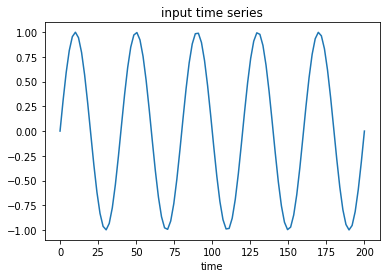

In [2]:
# create regular samples
N = 100
dt = 2 
times = np.linspace(0, N * dt, N)
# create sinusoidal signal
sin_freq = 1 / (2 * dt) / 10
print("sin freq is:", sin_freq)
data = np.sin(2 * np.pi * sin_freq * times)
plt.figure()
plt.title("input time series")
plt.xlabel("time")
plt.plot(times, data)


nyquist freq. is: 0.25


Text(0.5,0,'frequency')

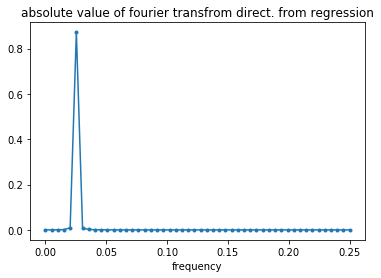

In [3]:
# create a frequency grid
gamma = 1 # an oversampling factor
df = 1 / (N * dt)
nyquist = 1 / (2 * dt) # nyquist limit, well defined for regular sampling
print("nyquist freq. is:", nyquist)
def frequencies(gamma=1):
    return np.linspace(0, nyquist, int(nyquist/(df/gamma)))

freqs = frequencies(gamma=gamma)
#print(len(freqs) * 2 == len(times)) # if gamma=1, this should be true

# create the dictionary
def phi(times, freqs):
    normal = np.exp(2j * np.pi * times.reshape(-1, 1) * freqs)
    return np.hstack((normal.real, normal.imag)) # we split real and imaginary part

# define the regressor
def regression():
    return linear_model.SGDRegressor(alpha=0.01, max_iter=500,
                                    tol=0.001, shuffle=True, penalty="l2",
                                    average=False, learning_rate="invscaling",
                                    eta0=0.01, power_t=0.1)
# fit the regression
def fit(reg, X, y):
    if hasattr(reg, 'coef_'):
        reg.coef_ = np.zeros(X.shape[1])
    reg.fit(X, y)
    
# get fourier transfrom
def ft(coefs):
    n_freq = int(len(coefs) / 2)
    ft = 1j * np.zeros(n_freq)
    for i in range(n_freq):
        ft[i] = coefs[i] + 1j * coefs[i + n_freq] # we join real and imaginary part
    return ft

reg = regression()
fit(reg, phi(times, freqs), data)
data_tilde = ft(reg.coef_)
plt.plot(freqs, abs(data_tilde)**2, '.-')
plt.title("absolute value of fourier transfrom direct. from regression")
plt.xlabel("frequency")

dentro de los calculos que requiere el match filter, existe una normalizacion por template que corresponde a:

$$ \sigma = \Delta f \sum_k |\tilde{h}[k]|^2$$

Donde $\tilde{h}$ corresponde a la transformada de fourier del template.

Dentro de las ambiciones del match filter para sampleo no regular esta la idea de poder utiliar un intervalo de frequencias personalizado, de forma de evitar tener que recurrir al limite de nyquist (complejo para sampleo irregular). Se espera que sin importar las frequencias que quiera calcular en la transformada realizada por la regresion, estas coincidan siempre con la transformada analitica y que el cambio en el sampleo de las frequencias permita suplir bajo el concepto de suma de riemman los cambios en la suma de los valores manteniendo $\sigma$ constante.

Pero observo que si utilizo diferentes frequencias el valor de los coeficientes en la regression cambia, lo que cambia el valor de $\sigma$ y me afecta al match filter. Puedo identificar una especie de dependencia con el factor $\gamma = \frac{2 * len(freq)} {len(times)}$ que permite obtener un comportamiento regular pero no logro comprender la razon de que esto ocurra. A continuacion unos graficos.

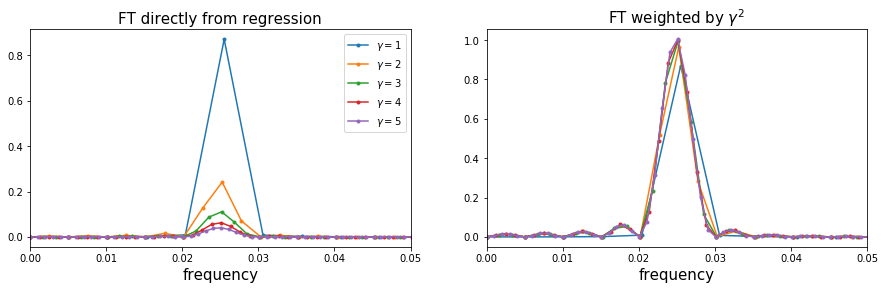

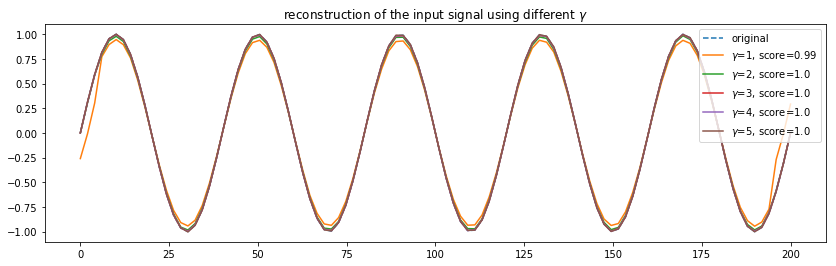

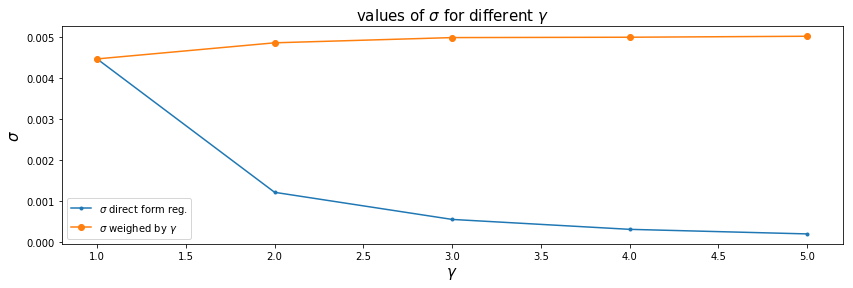

In [4]:
fsize=15
def foo():
    gammas = [1, 2, 3, 4, 5]
    reg = regression()
    data_tildes = []
    sum_tildes = []
    data_predict = []
    scores = []
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(15, 4), sharex=True)
    for gamma in gammas:
        freqs = frequencies(gamma=gamma)
        X = phi(times, freqs)
        fit(reg, X, data)
        d_tilde = ft(reg.coef_)
        ax1.plot(freqs, np.abs(d_tilde)**2, '.-', label=r"$\gamma=${}".format(gamma))
        ax2.plot(freqs, np.abs(d_tilde)**2 * (2*len(freqs)/len(times))**2, '.-')
        data_tildes.append(d_tilde)
        sum_tildes.append((np.abs(d_tilde)**2).sum() * df / gamma)
        data_predict.append(reg.predict(X))
        scores.append(reg.score(X, data))
    ax1.legend()
    plt.xlim([0, sin_freq + 5 * df])
    ax1.set_title("FT directly from regression", fontsize=fsize)
    ax2.set_title(r"FT weighted by $\gamma^2$ ", fontsize=fsize)
    ax1.set_xlabel("frequency", fontsize=fsize)
    ax2.set_xlabel("frequency", fontsize=fsize)
    
    plt.figure(figsize=(14, 4))
    plt.plot(times, data, '--', label="original")
    for i, predict in enumerate(data_predict):
        plt.plot(times, predict, label=r"$\gamma$={}, score={}".format(gammas[i], round(scores[i], 2)))
    plt.legend()
    plt.title(r"reconstruction of the input signal using different $\gamma$")
    
    # the riemman sum, i.e., value of sigma
    plt.figure(figsize=(14, 4))
    plt.plot(gammas, sum_tildes, '.-', label=r"$\sigma$ direct form reg.")
    weighted_sum_tildes = []
    for i in range(len(gammas)):
        weighted_sum_tildes.append(sum_tildes[i] * gammas[i]**2)
        
    plt.plot(gammas, weighted_sum_tildes, 'o-', label=r"$\sigma$ weighed by $\gamma$")
    plt.title(r"values of $\sigma$ for different $\gamma$", fontsize=fsize)
    plt.xlabel(r"$\gamma$", fontsize=fsize)
    plt.ylabel(r"$\sigma$", fontsize=fsize)
    plt.legend()
        
foo()
    
    